In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
# numpyro.enable_x64()

# Data

In [2]:
import pandas as pd

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable']).iloc[:, 0]
subset = full.loc['France']
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]
pop_fr = populations_country.loc['France']
infected = subset.loc[ix[:, 'total_cases']].replace(0, np.nan).dropna().values
total_deaths = subset.loc[ix[:, 'total_deaths']].loc['2020-02-15':].values
susceptible = pop_fr - infected
data = np.stack([susceptible, infected]).T
# data = infected

times = subset.loc[ix[:, 'total_cases']].replace(0, np.nan).dropna().index
# times = np.arange(times.shape[0])

# SI model
Inspired by the predator-prey tutorial and the PYMC3 ode blog post

We use first a SI model, of two populations:
- Susceptible (S)
- Infected (I)

The dynamics of populations is governed by a system of differential equations:
- $\frac{dS}{dt} = - R_0 S I$
- $\frac{dI}{dt} = R_0 S I$

In [3]:
def dz_dt(z, t, r0):
    s = np.clip(z[0], 0., 1.)
    i = np.clip(z[1], 0., 1.)
    ds_dt = - r0 * i * s
    di_dt = r0 * i * s
    return np.stack([ds_dt, di_dt])

si_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-3, mxstep=500)

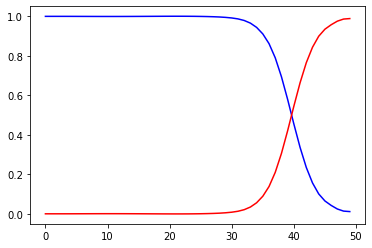

In [4]:
n_inf = 1e-7
res = si_int(np.array([1. - n_inf, n_inf]), np.arange(50.), 0.5)
plt.plot(res[:, 0], c='b')
plt.plot(res[:, 1], c='r')

In [5]:
def model(N, y=None):
    i_init = numpyro.sample('i_init', dist.LogNormal(loc=5, scale=1), sample_shape=(1,)) / pop_fr
    z_init = np.array([1. - i_init[0], i_init[0]])
    ts = np.arange(float(N))
    
    r0 = numpyro.sample('r0', dist.TruncatedNormal(low=0.1, loc=3.3, scale=1.0))
    
    z = si_int(z_init, ts, r0)
    
    sigma = numpyro.sample('sigma', dist.HalfCauchy(1.))
    
    numpyro.sample('y', dist.Normal(z, sigma), obs=y)

In [ ]:
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            500, 500, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data / pop_fr)
mcmc.print_summary()

warmup:   5%|▌         | 52/1000 [01:31<11:45,  1.34it/s, 1023 steps of size 1.95e-05. acc. prob=0.73]  

In [ ]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu, pi = np.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)
# mu = np.exp(mu)
# pi = np.exp(pi)

In [ ]:
# plt.plot(times, data[:, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67)
# plt.plot(times, np.log(data[:, 1]), "bx", label="true infected")
# plt.plot(times, mu[:, 0], "k-.", label="pred sane", lw=1, alpha=0.67)
plt.plot(times, mu[:, 1], "b--", label="pred infected")
# plt.fill_between(times, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(times, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(xlabel="date", ylabel="population")
# plt.title("Posterior predictive (80% CI) with predator-prey pattern.")
plt.legend()

plt.tight_layout()

In [ ]:
inference_data = az.from_numpyro(mcmc)
inference_data

In [ ]:
az.plot_trace(inference_data) ;

# SEIR-HCD


Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

In [ ]:
def dz_dt(z, t, r0, r1, t_lim, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
#     s = np.clip(z[0], 0., 1.)
#     e = np.clip(z[1], 0., 1.)
#     i = np.clip(z[2], 0., 1.)
#     r = np.clip(z[3], 0., 1.)
#     h = np.clip(z[4], 0., 1.)
#     c = np.clip(z[5], 0., 1.)
#     d = np.clip(z[6], 0., 1.)
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]
#     d = z[6]
    
    bl = t < t_lim
    rt = r0 * bl + (1 - bl) * r1
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

In [ ]:
n_inf = 1e-6
z_init = np.array([1. - n_inf, 0., n_inf, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

R_0 = 3.3
R_1 = 0.8
t_lim = 30.
t_inc = 5.6
t_inf = 2.9
t_hosp = 4.
t_crit = 14.
m_a = 0.8
c_a = 0.1
f_a = 0.35

args = (R_0, R_1, t_lim, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

res = seirhcd_int(z_init, ts, *args)
df_res = pd.DataFrame(res)
df_res.columns = 's e i r h c d'.split()
df_res.drop('s', axis=1).plot(figsize=(8, 5)) ;

In [ ]:
theta_esp = np.array([R_0, R_1, t_lim, t_inc, t_inf, t_hosp, t_crit])
fractions_esp = np.array([m_a, c_a, f_a])

def model(N, y=None):
#     i_init = numpyro.sample('i_init', dist.Uniform(low=1., high=10000.), sample_shape=(1,)) / pop_fr
    i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=1000., scale=100.), sample_shape=(1,)) / pop_fr
    z_init = np.array([1. - i_init[0], 0., i_init[0], 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
#     r0 = numpyro.sample('r0', dist.TruncatedNormal(low=0.1, loc=3.3, scale=1.0))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
#             low=np.array([1., 0.5, 40., 0., 0., 0., 0., 0., 0., 0.]),
            loc=theta_esp,
            scale=np.array([0.5, 0.4, 5., 3.,  5., 3., 5.])))
    
    r0 = np.clip(theta[0], 1., 4.)
    r1 = np.clip(theta[1], 0., 2.)
    
    fractions = numpyro.sample(
        'fractions',
        dist.TruncatedNormal(
            low=np.zeros(3),
            loc=np.array([0.8, 0.1, 0.35]),
            scale=np.array([0.1, 0.1, 0.1]),
            
#             loc=fractions_esp, 
#             scale=fractions_esp / 10
        )
    )
    fractions = np.clip(fractions, 0., 1.)
    
    z = seirhcd_int(z_init, ts, r0, r1, *theta[2:], *fractions)
#     total_cases = z[:, 2:].sum(axis=1)
    total_deaths = z[:, -1]
    sigma = numpyro.sample('sigma', dist.HalfCauchy(1.))
#     psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
#     numpyro.sample('y', dist.Normal(total_cases, sigma), obs=y)
    numpyro.sample('y', dist.TruncatedNormal(0, total_deaths, sigma), obs=y)

#     numpyro.sample('y', dist.GammaPoisson(psi*total_deaths, rate=psi), obs=y)

In [ ]:
data = total_deaths
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            500, 500, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data / pop_fr)
mcmc.print_summary()

In [ ]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu = np.mean(pop_pred, 0)
pi = np.percentile(pop_pred, (10, 90), 0)

In [ ]:
times = subset.loc[ix[:, 'total_deaths']].loc['2020-02-15':].index.map(onp.datetime64).to_numpy()

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(times, data / pop_fr, "bx", label="true")
plt.plot(times, mu, "b--", label="pred")
plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

In [ ]:
inference_data = az.from_numpyro(mcmc)
inference_data

az.plot_trace(inference_data) ;